# Heavy Traffic Indicators on I-94
*Jack Edelbrock, MS*

## Executive Summary
This project evaluates a dataset containing traffic volume and weather data for I-94W between Minneapolis and St.Paul. This analysis revealed significant temporal and weather-based variations in traffic volume. Traffic is heaviest in summer months and during weekday rush hours, while it is lightest when the weather is considered a 'squall'.

## Introduction

I-94 is a US interstate highway that traverses the north-central US connecting Detroit, Chicago, Milwaukee, Madison, Minneapolis/St.Paul, and Bismark. Understanding and predicting traffic patterns on this highway could help identify exacerbating factors for traffic jams, the ideal times to take the highway, the need for alternative routes, and opportunities for highway expansion.

### Goal

The goal of this project is to identify patterns in time and weather that might indicate heavy traffic on westbound I-94 between Minneapolis and St. Paul.

### Imports

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Allow figures to be shown inline within Jupyter
%matplotlib inline

# Suppress error message about too many figures open at once
plt.rcParams.update({'figure.max_open_warning': 0})

# Set default style
sns.set_theme(style='whitegrid')

### Dataset

The data used in this project, entitled 'Metro Interstate Traffic Volume', was collected by John Hogue, and is available at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume). The dataset includes several important traffic indicators collected at the midpoint on I-94W between Minneapolis and St. Paul, MN:

* **\[0\] holiday** - Text reporting the current holiday (ie: 'None', 'Labor Day')
* **\[1\] temp** - Air temperature in degrees kelvin
* **\[2\] rain_1h** - The amount of rain (in mm) that occured in the current hour
* **\[3\] snow_1h** - The amount of snow (in mm) that occured in the current hour
* **\[4\] clouds_all** - The percent cloud cover
* **\[5\] weather_main** - Short categorical text reporting the current weather ('Clouds', 'Thunderstorm')
* **\[6\] weather_description** - Longer categorical text reporting the current weather (ie: 'broken clouds', 'proximity thunderstorm')
* **\[7\] date_time** - DateTime Hour of the datapoint in CST
* **\[8\] traffic_volume** - Numeric Hourly I-94 westbound traffic volume

In [2]:
traffic = pd.read_csv('./DataSets/I94Traffic/Metro_Interstate_Traffic_Volume.csv')

## Data Cleaning

### Data Type Conversion

First, convert the data columns into their usable types:

In [3]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

for column in traffic.columns:
    print(f'Column {column} is currently a {type(traffic[column][0])}')

Column holiday is currently a <class 'str'>
Column temp is currently a <class 'numpy.float64'>
Column rain_1h is currently a <class 'numpy.float64'>
Column snow_1h is currently a <class 'numpy.float64'>
Column clouds_all is currently a <class 'numpy.int64'>
Column weather_main is currently a <class 'str'>
Column weather_description is currently a <class 'str'>
Column date_time is currently a <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Column traffic_volume is currently a <class 'numpy.int64'>


### Removing Outliers

* **temp** - One datapoint represented as 0K (or absolute zero). *Although it gets objectively cold in the twin-cities area*, it does not approach complete cessation of molecular motion. I removed this datapoint from the analysis.
* **rain_1h** - One datapoint reported ~10,000mm of rain in one hour. This would place most of the city and surrounding area fully underwater. I removed this datapoint from the analysis.

In [4]:
absolute_zero_bool = traffic['temp'] == 0
flood_bool = traffic['rain_1h'] > 1000
traffic = traffic.loc[(~flood_bool & ~absolute_zero_bool), :]

## Functions

In [5]:
'''
Function to create a Seaborn plot of a certain time frame, with the option of adding an additional filter bool

Arguments: 
    hour_start = the inclusive starting hour for the time period
    hour_end   = the exclusive end hour for the time period
    other_bool = an additional filtering bool to apply to the data, such as weekday_bool
    x_lim      = the maximum value on the x axis
    y_lim      = the maximum value on the y axis

Returns:
    median = median of the selected dataset
    mean   = mean of the selected dataset
'''
def plot_time_period(hour_start, hour_end, other_bool = True,     \
                     x_lim = 8000, y_lim = 400):
    
    # Isolate the hours of interest based on the arguments
    hour_bool = (traffic['date_time'].dt.hour >= hour_start)                    \
            & (traffic['date_time'].dt.hour < hour_end) & other_bool
    hour_data = traffic.loc[hour_bool, :]
    
    # Collect statistics for the hours of interest
    median = hour_data.loc[:,'traffic_volume'].median()
    mode   = hour_data.loc[:,'traffic_volume'].mean()
    
    # Create the plot and set important plot characteristics
    ax = sns.displot(hour_data, x = 'traffic_volume', bins = 120,  \
                height = 2, aspect = 6,                            \
                facet_kws=dict({'margin_titles':True}),            \
                binrange = (0,x_lim))                              \
                .set(title = f'Traffic Volume from {hour_start}:00 to {hour_start}:59')
    ax.set(xlim=(0,x_lim))
    ax.set(ylim=(0,y_lim))
        
    return [median, mode]

## Data Exploration

### Aggregate Traffic Volume

Traffic volume is given as the number of vehicles moving westbound on I94 over the period of an hour. A histogram of the entire dataset is shown below:

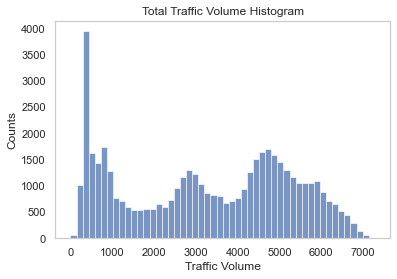

<Figure size 432x288 with 0 Axes>

In [6]:
sns.histplot(traffic['traffic_volume'], bins = 50)
plt.title('Total Traffic Volume Histogram')
plt.xlabel('Traffic Volume')
plt.ylabel('Counts')
plt.grid(False)
plt.show()
plt.clf()

 Examining the aggregate data as a histogram, we can make several observations:
- Traffic volume ranges from 0 to over 7,000 vehicles/hour.
- There appear to be several overlapping traffic distributions. One centered at 2,900, one at 4,800, and one at 5,900.
- The mode is a nearly empty highway, around 200 vehicles/hour.

I hypothesize that these different distributions relate to different times of day. For instance, one distribution might be from the evening rush hour, while another might be from the morning rush hour. Yet another distribution could be from the likely different weekend traffic patterns.

### Temporal traffic distributions

I examined temporal traffic patterns in a top-down fashion: monthly, daily, and then hourly

#### Monthly traffic patterns

The range of average daily traffic by month is 395
The daily traffic pattern by month varies by 12% of the maximum value


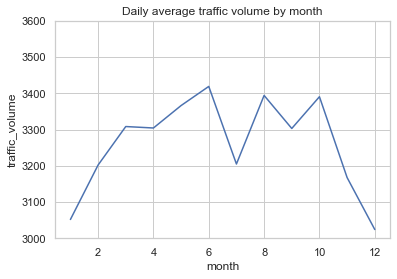

In [7]:
# Group data by month and collect mean data for each month
traffic.loc[:,'month'] = traffic.loc[:,'date_time'].dt.month
month_grouped = traffic.groupby('month').mean()

# Plot and set plot parameters
ax = sns.lineplot(data=month_grouped, x='month',y='traffic_volume')
plt.title('Daily average traffic volume by month')
ax.set(ylim=(3000,3600))

# Calculate statistics of the data
monthly_max = month_grouped.loc[:,'traffic_volume'].max()
monthly_min = month_grouped.loc[:,'traffic_volume'].min()
monthly_range = monthly_max - monthly_min
percent_variance = monthly_range / monthly_max

print(f'The range of average daily traffic by month is {monthly_range:.0f}')
print(f'The daily traffic pattern by month varies by {percent_variance * 100:.0f}% of the maximum value')

**NB:** *The graph above is scaled to ~15% of the maximum daily traffic by month to show detail. The actual magnitude of variance is much less prominent.*

The variance in daily traffic volume in each month has a range of about traffic volume by month is a bit more than 10%, which I believe indicates a summer seasonal traffic increase (perhaps due to vacation travel), superimposed on stable baseline traffic (most jobs that require a daily commute are not seasonal).

#### Traffic volume by day-of-week

The range of traffic volume by day-of-week is 1287
The variance in traffic volume by day-of-week is 35%
The range of traffic volume throughout the week is 535
The variance in traffic volume by day-of-business-week is 19%


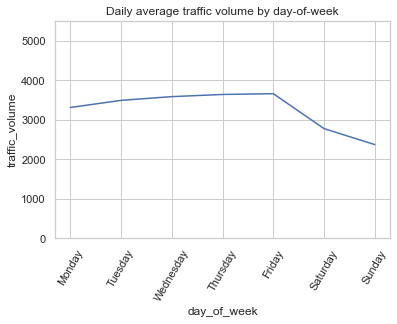

In [8]:
# Group datapoints by day-of-the-week
traffic.loc[:,'day_of_week'] = traffic.loc[:,'date_time'].dt.dayofweek
day_grouped = traffic.groupby('day_of_week')  \
                        .mean()               \
                        .reset_index()

# Transform day numbers to strings
day_grouped.loc[:,'day_of_week'] = ['Monday','Tuesday','Wednesday',            \
                                    'Thursday','Friday','Saturday','Sunday']

# Plot chart and set chart parameters
ax = sns.lineplot(data=day_grouped,
                 x='day_of_week',
                 y='traffic_volume',
                 color='b')
plt.title('Daily average traffic volume by day-of-week')
plt.xticks(rotation = 60)
ax.set(ylim=(0,5500))

# Calculate vital statistics of the data
day_of_week_min = day_grouped.loc[:,'traffic_volume'].min()
day_of_week_max = day_grouped.loc[:,'traffic_volume'].max()
day_of_week_range = day_of_week_max - day_of_week_min
day_of_week_variance = day_of_week_range / day_of_week_max
day_of_week_weekday_range = day_grouped.loc[0,'traffic_volume']    \
                                - day_grouped.loc[5,'traffic_volume']
day_of_week_weekday_variance = day_of_week_weekday_range           \
                                / day_grouped.loc[5,'traffic_volume']

print(f'The range of traffic volume by day-of-week is {day_of_week_range:.0f}')
print(f'The variance in traffic volume by day-of-week is {day_of_week_variance * 100:.0f}%')
print(f'The range of traffic volume throughout the week is {day_of_week_weekday_range:.0f}')
print(f'The variance in traffic volume by day-of-business-week is {day_of_week_weekday_variance * 100:.0f}%')



The decrease in traffic volume on Saturday (day 5) and Sunday (day 6) is likely due to less commuter traffic on the weekend. The variance between the week and the weekend is significant at 35%. Within the week, the traffic volume steadily increases from Monday to Friday. Overall, this represents a 19% change in traffic volume.

#### Traffic volume by day-of-business-week

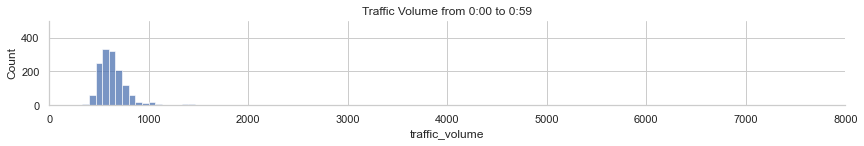

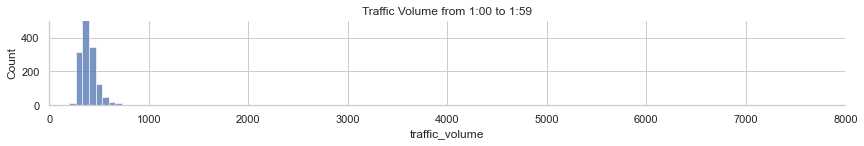

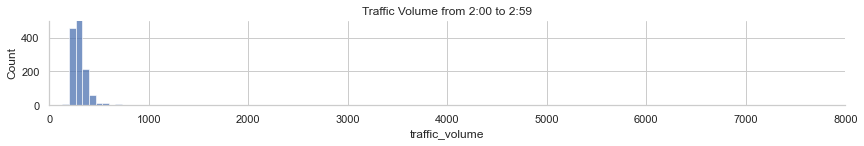

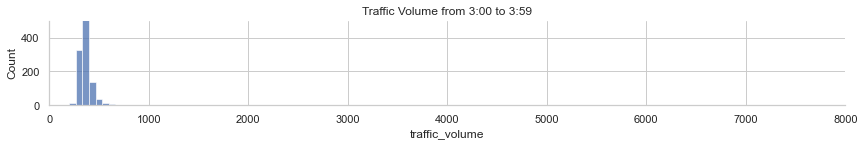

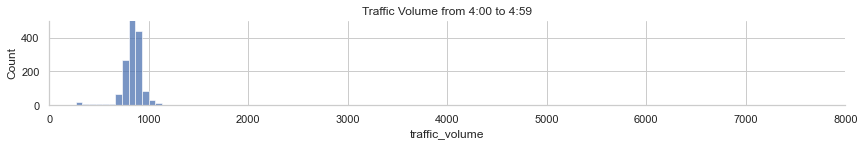

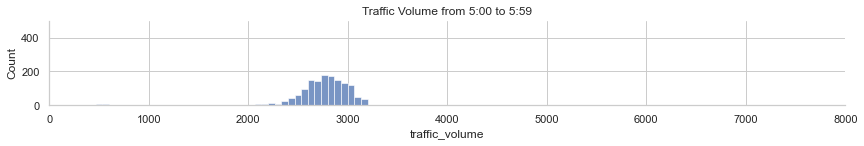

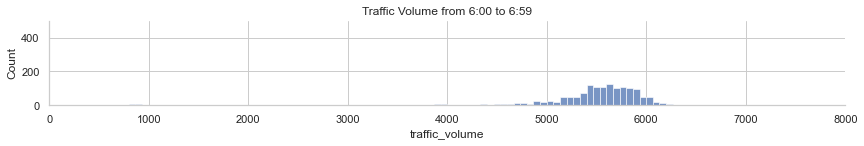

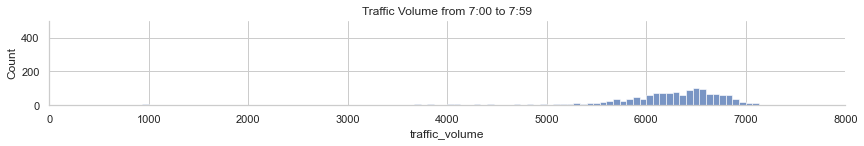

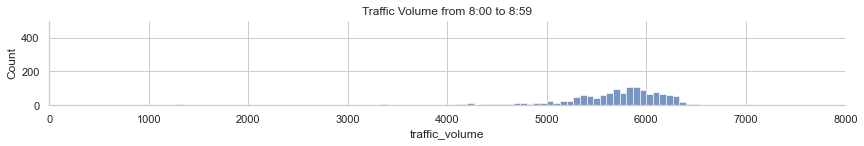

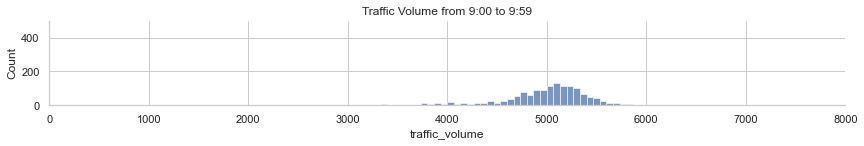

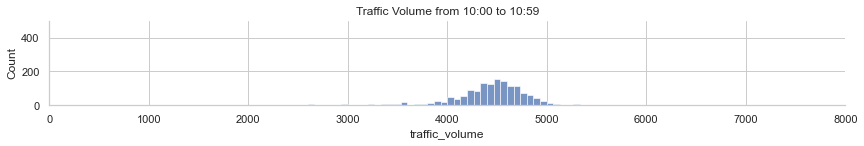

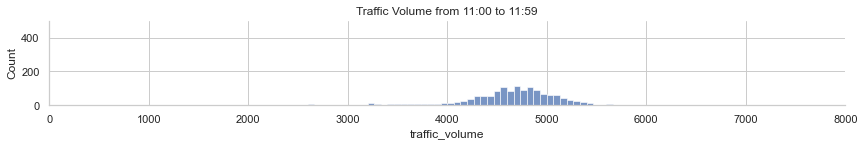

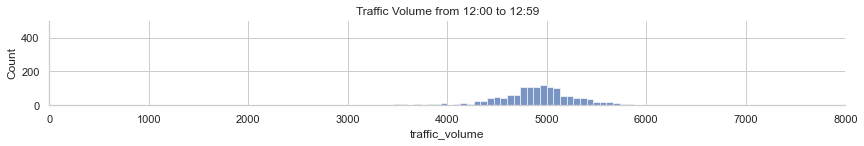

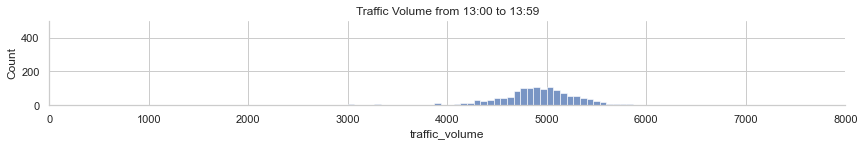

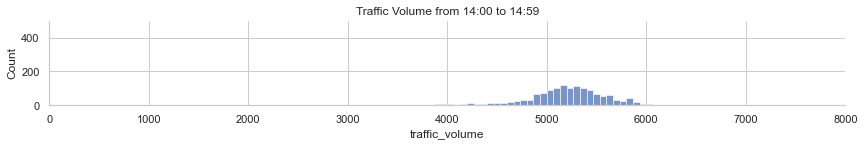

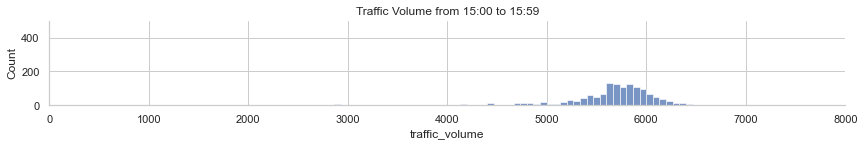

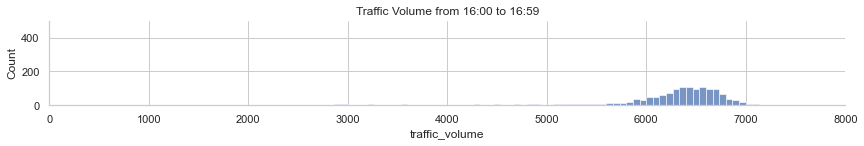

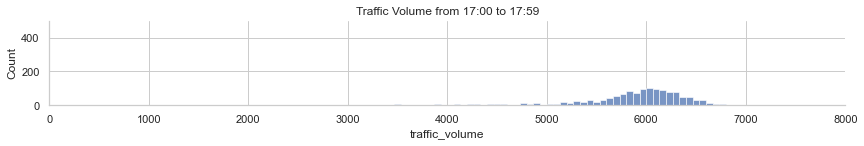

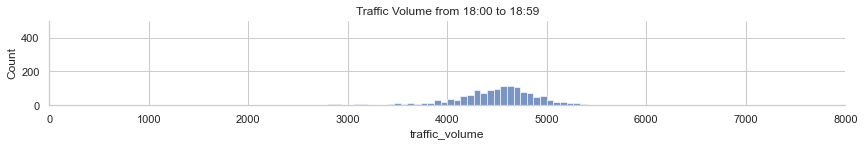

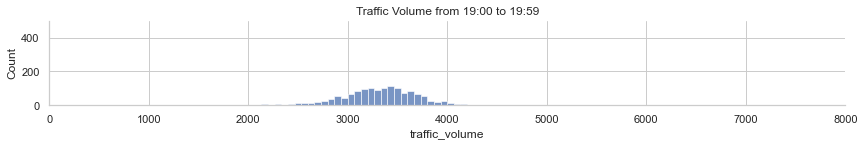

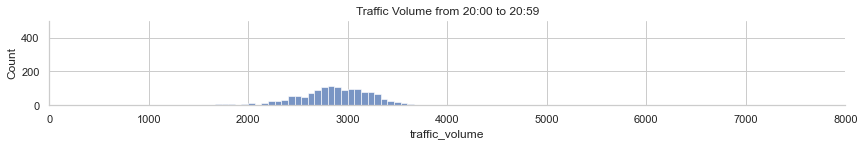

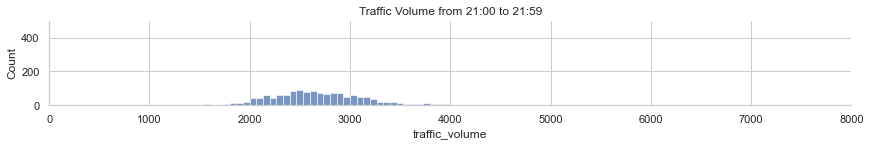

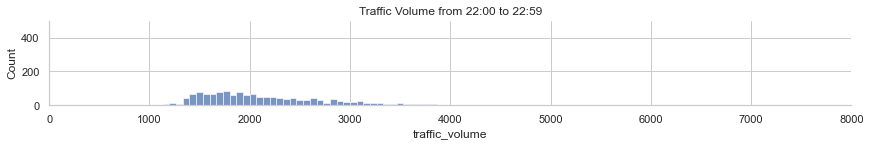

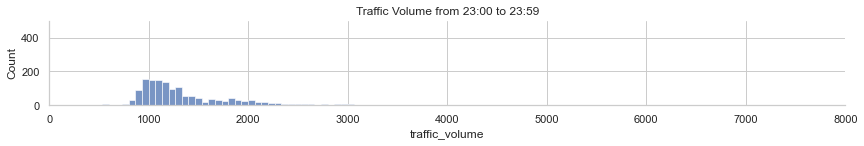

In [9]:
# Isolate data of interest
weekday_bool = (traffic.loc[:,'date_time'].dt.weekday < 5)

# Define dictionaries to hold statistics calulated by the plot_time_period function (defined above)
hourly_mean_weekdays = {}
hourly_median_weekdays = {}

#   Call the plot_time_period function (defined above) to plot a histogram
# for each hour of the business week.
for i in range(0,24):
    [median_i, mean_i] = plot_time_period(i,i+1, weekday_bool, 8000, 500)
    hourly_median_weekdays[i] = median_i
    hourly_mean_weekdays[i]   = mean_i

The graphs above show a distinct bi-modal traffic pattern corresponding to the morning and evening rush hours. The morning rush hour peaks in the 7a hour, and the evening rush peaks in the 4p hour. Minimal daytime traffic is at 10a, and minimal nightime traffic is at 3a.

#### Traffic volume by day-of-weekend

Examining the traffic patterns on an hour-by-hour basis during the weekend:

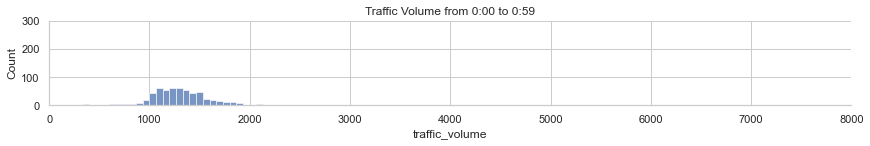

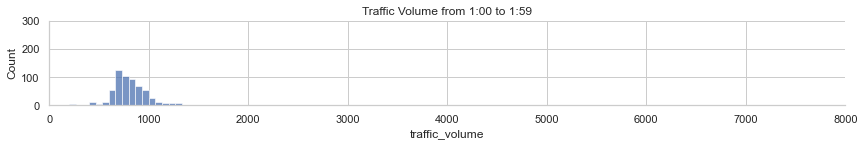

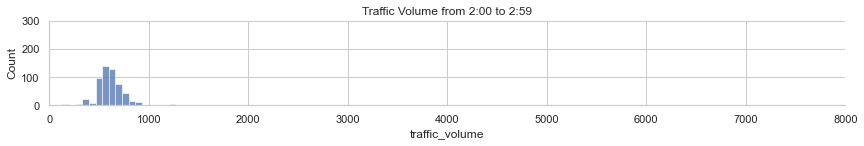

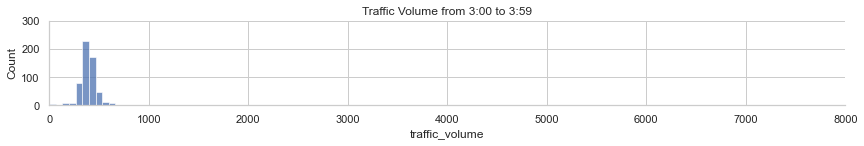

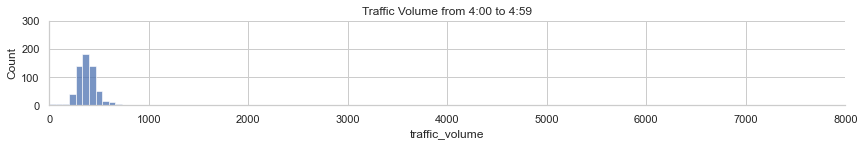

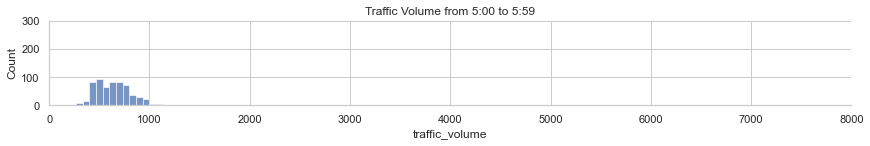

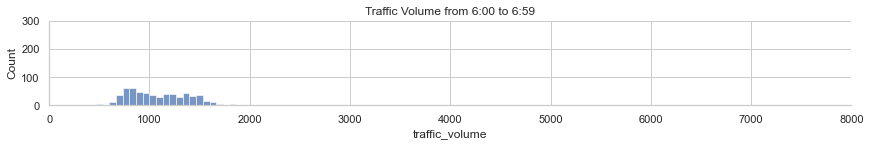

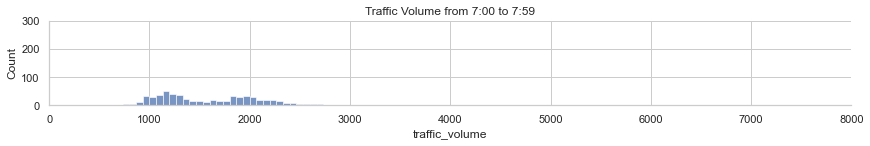

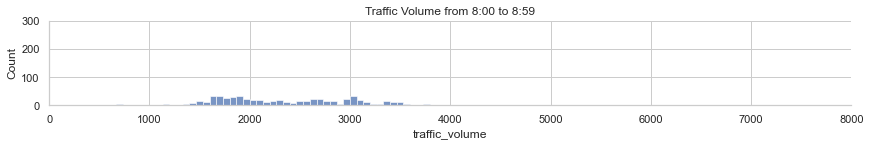

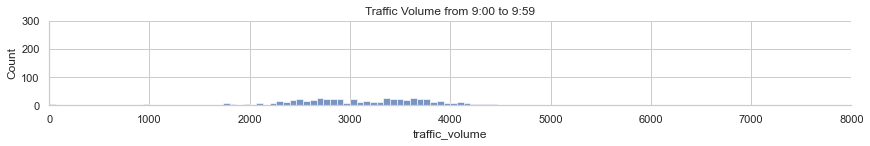

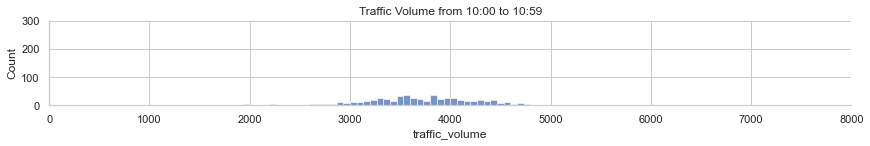

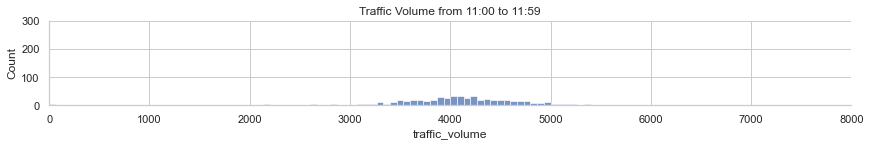

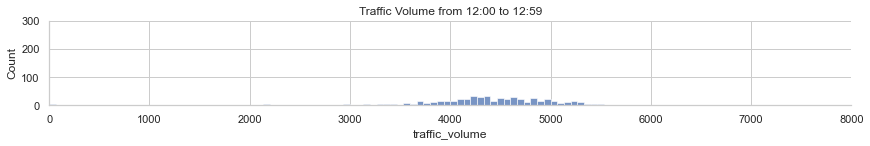

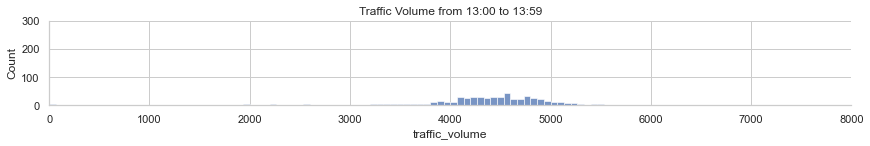

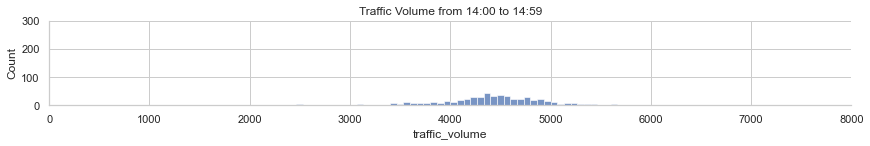

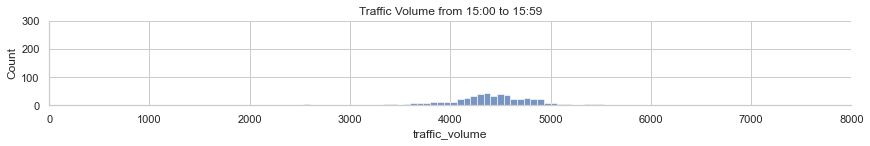

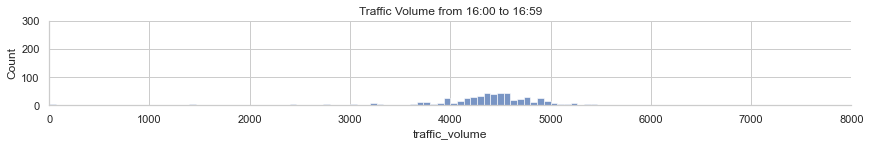

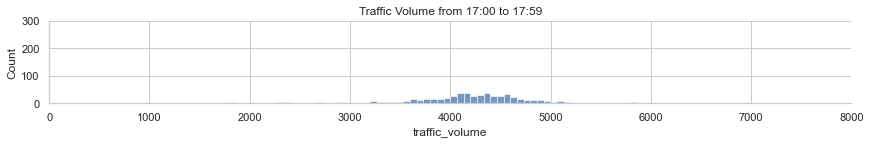

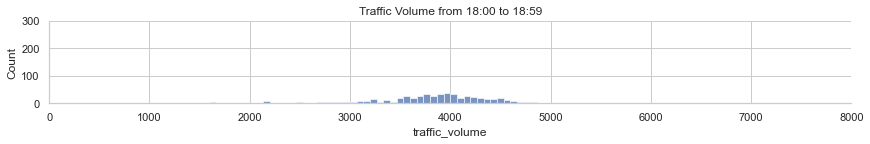

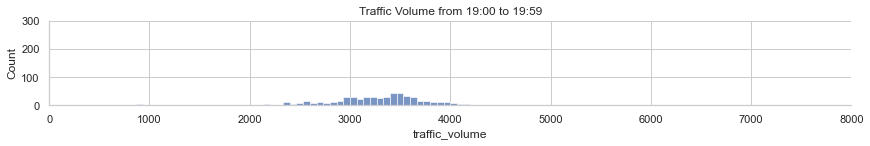

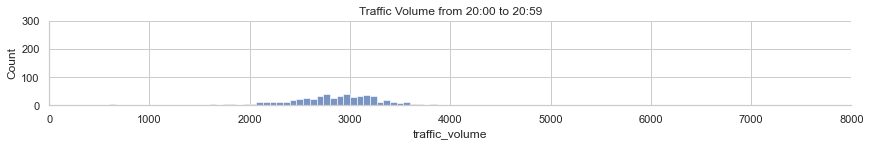

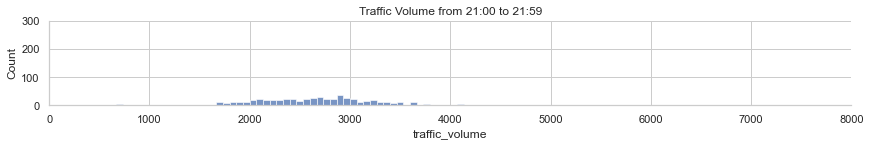

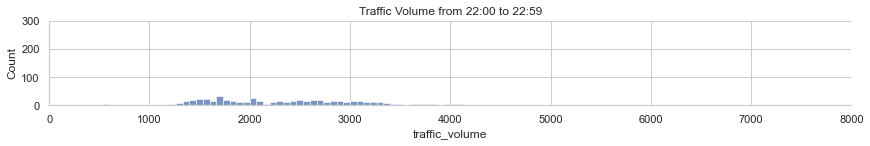

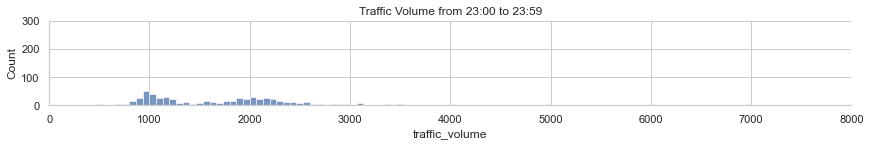

In [10]:
# Define dictionaries to hold statistics from the plot_time_period function (defined above)
hourly_median_weekends = {}
hourly_mean_weekends = {}

#    Call the plot_time_period function (defined above) to plot a histogram
# for each hour of the weekend
for i in range(0,24):
    [median_i, mean_i] = plot_time_period(i,i+1, ~weekday_bool, 8000, 300)
    hourly_median_weekends[i] = median_i
    hourly_mean_weekends[i]   = mean_i

Although the daytime/nighttime traffic pattern is preserved on the weekend, it appears that it is phase shifted, with the overnight minimum occuring at 5a, and the daytime maximum occuring at 1p hour.

This pattern is better visualized by examining the median traffic value as a function of hour, as shown below:


<AxesSubplot:xlabel='Hour', ylabel='Median Traffic Volume'>

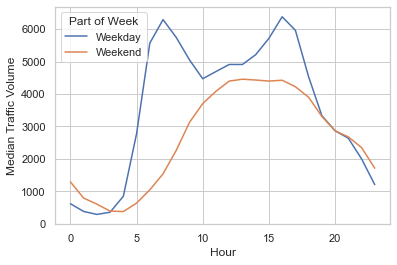

In [11]:
hourly_medians = pd.DataFrame({'Median Traffic Volume':hourly_median_weekdays, 'Part of Week':'Weekday'})             \
                    .append(pd.DataFrame({'Median Traffic Volume':hourly_median_weekends, 'Part of Week':'Weekend'}))
hourly_medians = hourly_medians.reset_index()
hourly_medians.columns = ['Hour', 'Median Traffic Volume', 'Part of Week']

hourly_means = pd.DataFrame({'Mean Traffic Volume':hourly_mean_weekdays, 'Part of Week':'Weekday'})                   \
                .append(pd.DataFrame({'Mean Traffic Volume':hourly_mean_weekends, 'Part of Week':'Weekend'}))

hourly_means = hourly_means.reset_index()
hourly_means.columns = ['Hour', 'Mean Traffic Volume', 'Part of Week']

sns.lineplot(data=hourly_medians, x='Hour', y='Median Traffic Volume', hue='Part of Week')

This chart corroborates, and summarizes the histogram data shown above. It shows a bimodal weekday traffic volume, while the weekend traffic pattern is phase shifted forward with a monomodal distribution.

### Traffic volume dependence on weather

#### Correlation coefficients for quantitative weather variables

Before evaluating any quantitative weather metrics in depth, I performed a screen of each using correlation coefficients.

In [12]:
# Determine correlation coefficients
temp_vol_corr = (traffic.loc[:,   'temp']).corr(traffic.loc[:,'traffic_volume'])
rain_vol_corr = (traffic.loc[:,'rain_1h']).corr(traffic.loc[:,'traffic_volume'])
snow_vol_corr = (traffic.loc[:,'snow_1h']).corr(traffic.loc[:,'traffic_volume'])

print(f'Correlation Coefficients')
print(f'------------------------')
print(f'Temp/Volume = {temp_vol_corr:.2f}')
print(f'Rain/Volume = {rain_vol_corr:.2f}')
print(f'Show/Volume = {snow_vol_corr:.2f}')

Correlation Coefficients
------------------------
Temp/Volume = 0.13
Rain/Volume = -0.02
Show/Volume = 0.00


Based on these coefficients, I decided only the temperature/volume relationship indicated further analysis

#### Traffic volume dependence on temperature

Text(0.5, 1.0, 'Traffic volume vs Temperature')

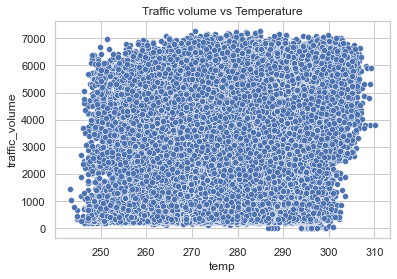

In [13]:
ax = sns.scatterplot(data=traffic,x='temp',y='traffic_volume')
plt.title('Traffic volume vs Temperature')

Although the correlation between temperature and traffic volume is strongest, it is still weak, and not readily apparent on the plot abvove. I hypothesize that the marginally increased traffic in warmer weather could correspond to the summer month increased traffic demonstrated previously.

#### Non-numeric weather descriptors: 'weather_main'

The 'weather_main' column within the original dataset gives basic weather information, such as 'thunderstorm', 'fog', 'clear', and 'snow'.

The range in traffic volumes aggregated by 'weather_main' is 1557
The variance in traffic volumes aggregated by 'weather_main' is 43%


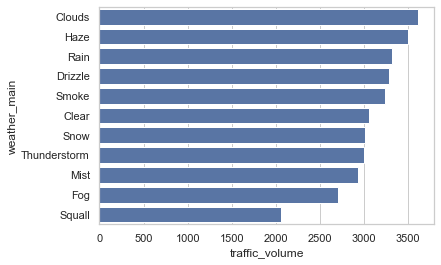

In [14]:
# Group data by 'weather_main' category and collect mean statistics
by_weather_main = traffic.groupby('weather_main').mean()          \
                    .reset_index()                                \
                    .sort_values('traffic_volume',ascending=False)

# Plot results
sns.barplot(data=by_weather_main,
            y='weather_main',
            x='traffic_volume',
            color='b')

# Calculate statistics
weather_main_max = by_weather_main['traffic_volume'].max()
weather_main_min = by_weather_main['traffic_volume'].min()
weather_main_range = weather_main_max - weather_main_min
weather_main_variance = weather_main_range / weather_main_max

print(f'The range in traffic volumes aggregated by \'weather_main\' is {weather_main_range:.0f}')
print(f'The variance in traffic volumes aggregated by \'weather_main\' is {weather_main_variance * 100:.0f}%')

The overall variance in traffic volume aggregated by 'weather_main' is over 40%, indicating that certain weather conditions cause a significant deviation from normal traffic patterns. Squalls cause the largest drop in traffic, while the highest traffic volumes occur with clouds.

#### Non-numeric weather descriptors: 'weather_description'

The 'weather_description' column within the original dataset gives detailed weather information, such as 'thunderstorm with light rain', 'very heavy rain', 'broken clouds', and 'haze'.

The range in traffic volumes aggregated by 'weather_main' is 3602
The variance in traffic volumes aggregated by 'weather_main' is 64%


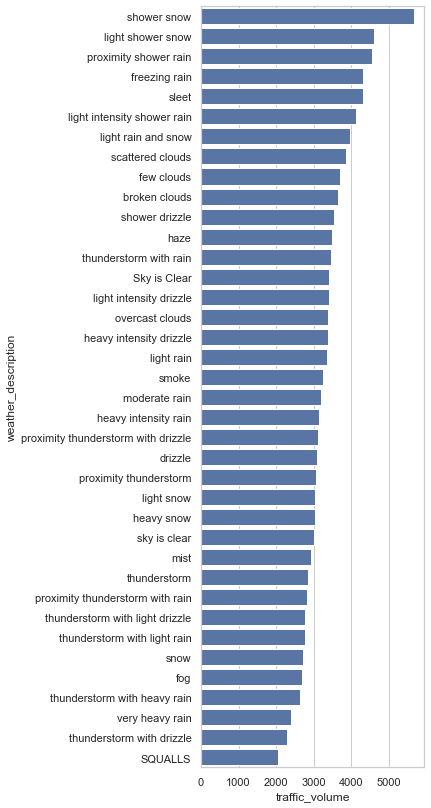

In [15]:
# Group data by 'weather_description' categoreis and collect mean data
by_weather_description = traffic.groupby('weather_description').mean()     \
                            .reset_index()                                 \
                            .sort_values('traffic_volume',ascending=False)

plt.subplots(figsize=(4,14))
sns.barplot(data=by_weather_description,
            y='weather_description',
            x='traffic_volume',
            color='b')

# Calculate statistics
weather_description_max = by_weather_description['traffic_volume'].max()
weather_description_min = by_weather_description['traffic_volume'].min()
weather_description_range = weather_description_max - weather_description_min
weather_description_variance = weather_description_range / weather_description_max

print(f'The range in traffic volumes aggregated by \'weather_main\' is {weather_description_range:.0f}')
print(f'The variance in traffic volumes aggregated by \'weather_main\' is {weather_description_variance * 100:.0f}%')

Because of the larger number of categories present in this analysis, the difference between the minimum traffic volume category, 'SQUALLS', and the maximum traffic volume category, 'shower snow' is 3,602, or 64%. In this analysis, traffic appears to be heaviest in transition periods between types of precipitation (shower snow, sleet).

## Conclusion

This project evaluated the 'Metro Interstate Traffic Volume' dataset for temporal and weather-based variations in traffic volume. Based on my evaluation of the data, traffic is heaviest in the following conditions:
* The morning (7a) and evening (4p) rush hours
* Warmer weather, specifically summer months
* Weekdays
* Transitional weather patterns, such as 'sleet' and 'mixed precipitation (snow/rain)'.

Traffic appears to be lightest in the following conditions:
* The middle of the night
* The middle of the day
* Weekends
* In squall weather conditions